In [1]:
from sentence_transformers import SentenceTransformer
from PIL import Image

import numpy as np
import openai
import pandas as pd
import pickle
import uuid
import pinecone
#from tqdm.auto import tqdm
import datetime
from time import sleep
import traceback
from dotenv import load_dotenv
import os
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

c:\Users\mjz\source\repos2\chainlit-langchain-pinecone\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

IMAGE_PINECONE_API_KEY = os.getenv("IMAGE_PINECONE_API_KEY")
IMAGE_PINECONE_ENV = os.getenv("IMAGE_PINECONE_ENV")

In [5]:
# initialize connection (get API key at app.pinecone.io)
def initPinecone(index_name:str, pinecone_api_key:str, pinecone_env:str, dimension_len:int = 1536) -> pinecone.Index:
    pinecone.init(
        api_key=pinecone_api_key,
        #environment="asia-southeast1-gcp"  # find next to API key  #us-central1-gcp #asia-southeast1-gcp
        environment=pinecone_env
    )
        #environment="us-central1-gcp"  # find next to API key
    # check if index already exists (it shouldn't if this is first time)
    if index_name not in pinecone.list_indexes():
    # if does not exist, create index
        pinecone.create_index(
            index_name,
            dimension=dimension_len,
            metric='cosine',
            metadata_config={
                'indexed': ['title', 'heading']
            }
        )

    # connect to index
    return pinecone.Index(index_name)

In [6]:
def generate_vector(id, values, metadata):
    return {
        'id': id,
        'values': values,
        'metadata': { 'image_name': metadata }
    }

In [10]:
def seed_upsert(index: pinecone.Index):
    # Load CLIP model
    model = SentenceTransformer('clip-ViT-B-32')

    img_data = []

    img_data.append("001.png")
    img_data.append("002.png")
    img_data.append("003.png")
    img_data.append("004.png")

    to_upsert = []
    for item in img_data:
        uid = str(uuid.uuid4())
        embedding = model.encode(Image.open('./images/' + item))
        embedding_list = embedding.tolist()
        vector = generate_vector(id=uid,values=embedding_list,metadata=item)
        to_upsert.append(vector)
        #print(vector)
   
    # print(to_upsert)
    # view index stats
    """
    
    """
    print(index.describe_index_stats())

    index.upsert(vectors=to_upsert)

    # view index stats
    print(index.describe_index_stats())
    print(to_upsert)




In [30]:
def search(index: pinecone.Index, query:str):
    model = SentenceTransformer('clip-ViT-B-32')

    # Encode text query
    query_string = query
    text_emb = model.encode(query_string)

    #print(text_emb)

    text_emb_list = text_emb.tolist()

    results = index.query(vector=text_emb_list,top_k=1,include_metadata=True)

   
    print(results)

    image_name = results['matches'][0]['metadata']['image_name']
    
    plt.title(image_name)
    image = mpimg.imread('./images/' + image_name)
    plt.imshow(image)
    plt.show()
    
    

In [8]:
index_name = "osha-images-index"

index = initPinecone(index_name=index_name,pinecone_api_key=IMAGE_PINECONE_API_KEY,pinecone_env=IMAGE_PINECONE_ENV,dimension_len=512)
seed_upsert(index)

{'matches': [{'id': '76d2ff3c-5125-4aae-ac07-5bfd3b5fc86f',
              'metadata': {'image_name': '001.png'},
              'score': 0.263194,
              'values': []}],
 'namespace': ''}


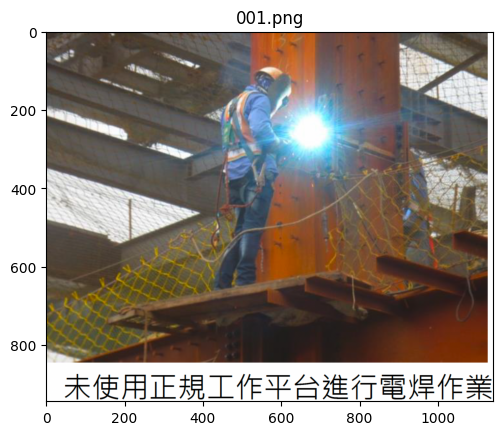

In [32]:
index_name = "osha-images-index"

index = initPinecone(index_name=index_name,pinecone_api_key=IMAGE_PINECONE_API_KEY,pinecone_env=IMAGE_PINECONE_ENV,dimension_len=512)

search(index=index, query="worker")